Experiment with sampling from distribution functions

In [110]:
import math
import warnings

import astropy.coordinates as coord
from astropy.constants import G
import astropy.units as u
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.integrate import quad

from gala.mpl_style import mpl_style
import gala.potential as gp
import gala.dynamics as gd
from gala.units import dimensionless

plt.style.use('apw-notebook')
%matplotlib inline

### Hernquist with:
### $G=M=a=1$

In [2]:
pot = gp.HernquistPotential(m=1., c=1., units=dimensionless)

In [64]:
N_orbits = 1024

In [70]:
def sample_radii(pot, size=1, r_min=0.*u.kpc, r_max=np.inf*u.kpc):
    r_min = r_min.to(u.kpc).value
    r_max = r_max.to(u.kpc).value
    
    # hernquist-specific
    Menc = lambda rr: rr**2 / (1+rr)**2
    Mtot = 1.
    
    def root_func(r, m):
        return (m - Menc(float(r))/Mtot)
    
    if r_min == 0.:
        m_min = 0.
    else:
        m_min = Menc(r_min)/Mtot
        
    if r_max == np.inf:
        m_max = 1.
    else:
        m_max = Menc(r_max)/Mtot
    
    m = np.random.uniform(m_min, m_max, size=size)
    return np.array([root(root_func, 1., args=(m[i],)).x[0] for i in range(size)])

In [74]:
r = sample_radii(pot, N_orbits)

In [75]:
xyz = np.zeros((3,r.size))
xyz[0] = r

## Make sure the sampled radii follow the correct profile

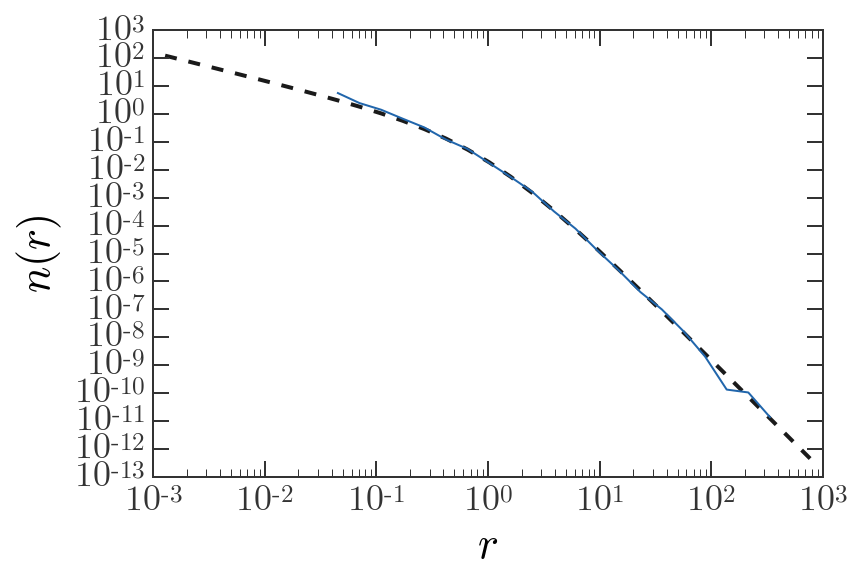

In [86]:
bins = np.logspace(-3, 3, 32)
H,_ = np.histogram(r, bins=bins)

V = 4/3*np.pi*(bins[1:]**3 - bins[:-1]**3)
bin_cen = (bins[1:]+bins[:-1])/2.

q = np.zeros((3,len(bin_cen)))
q[0] = bin_cen
plt.plot(bin_cen, pot.density(q) / pot.parameters['m'], marker=None, lw=2., ls='--')

plt.loglog(bin_cen, H/V/r.size, marker=None)

plt.xlabel('$r$')
plt.ylabel('$n(r)$')

In [68]:
def hernquist_df(curly_E_tilde):
    E = curly_E_tilde
    
    A = (np.sqrt(2)*(2*np.pi)**3)**-1 * np.sqrt(E) / (1-E)**2
    term1 = (1 - 2*E)*(8*E**2 - 8*E - 3)
    term2 = 3*np.arcsin(np.sqrt(E)) / np.sqrt(E*(1-E))
    
    return A * (term1 + term2)

### Compare to Figure 4.2 in BT08

/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in arcsin
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


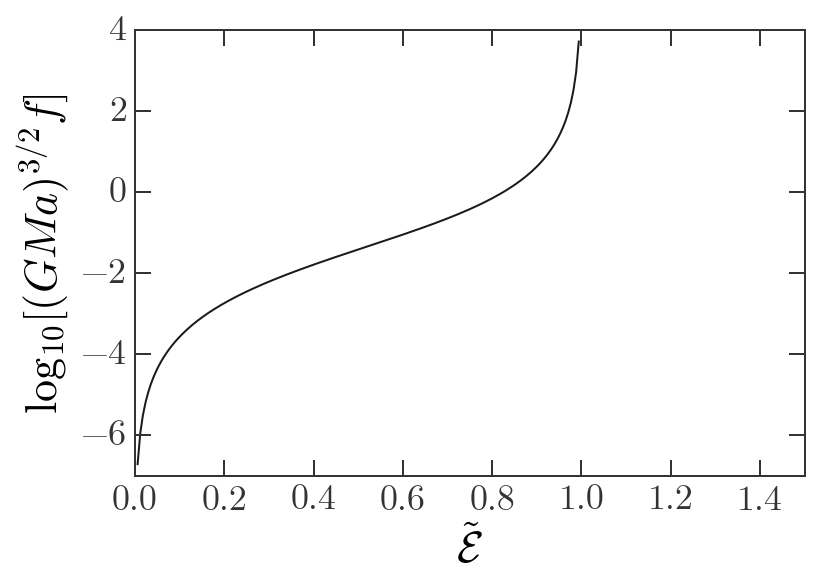

In [9]:
eee = np.linspace(0, 1.5, 256)

plt.plot(eee, np.log10(hernquist_df(eee)), marker=None)
plt.xlim(0,1.5)
plt.ylim(-7, 4)
plt.xlabel(r'$\tilde{\mathcal{E}}$')
plt.ylabel(r'$\log_{10}[(GMa)^{3/2} f]$')

In [28]:
def _hernquist_df(E):    
    A = (math.sqrt(2)*(2*math.pi)**3)**-1 * math.sqrt(E) / (1-E)**2
    term1 = (1 - 2*E)*(8*E**2 - 8*E - 3)
    term2 = 3*math.asin(math.sqrt(E)) / math.sqrt(E*(1-E))
    
    return A * (term1 + term2)

def _potential(r):
    return -1. / (r + 1.)

def vel_dist(v, r):
    E = 0.5*v**2 + _potential(r)
    curly_E = -E
    if curly_E <= 0. or curly_E >= 1.:
        return 0.
    return v**2 * _hernquist_df(curly_E)

def ln_vel_dist(p, r):
    v = p[0]
    if v <= 0.:
        return -np.inf
    f = vel_dist(v, r)
    if f == 0:
        return -np.inf
    return math.log(f)

In [87]:
# _vs = np.linspace(0, 1., 1024)
# plt.plot(vs, [ln_vel_dist([vv],r[144]) for vv in vs])
# # plt.plot(_vs, [vel_dist(vv,r[144]) for vv in _vs])

In [84]:
nwalkers = 32
v = np.zeros_like(r)

with warnings.catch_warnings():
    warnings.filterwarnings('error')
    
    for i in range(N_orbits):
        p0 = np.abs(np.random.normal(1E-3, 1E-3, (nwalkers,1)))
        sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=1, lnpostfn=ln_vel_dist, args=(r[i],))
        
        try:
            _ = sampler.run_mcmc(p0, 128)
        except Warning:
            print("Failed!", i)
            break
        v[i] = sampler.chain[0,-1,0]

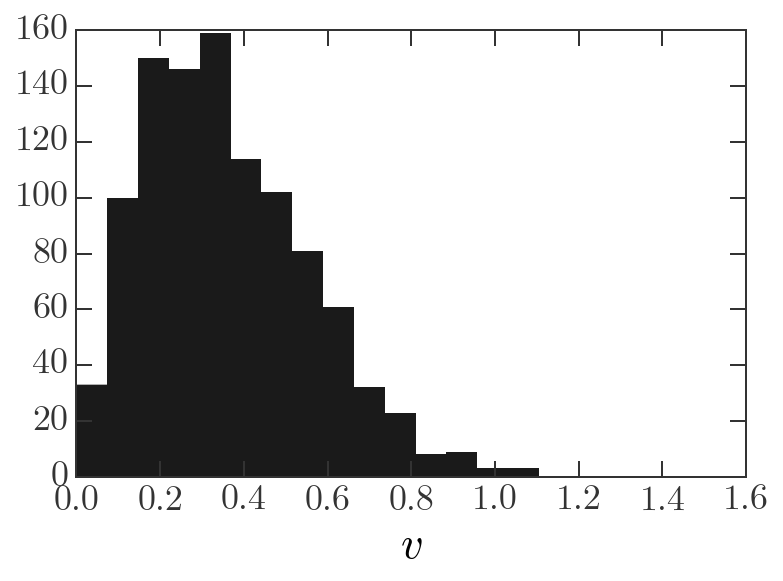

In [89]:
plt.hist(v, bins=np.linspace(0, 1.4, 20))
plt.xlabel("$v$")

In [129]:
def r_v_to_3d(r, v):
    phi = np.random.uniform(0, 2*np.pi, size=r.size)
    theta = np.arccos(2*np.random.uniform(size=r.size) - 1)
    sph = coord.PhysicsSphericalRepresentation(phi=phi*u.radian, theta=theta*u.radian, r=r*u.one)
    xyz = sph.represent_as(coord.CartesianRepresentation).xyz
    
    phi_v = np.random.uniform(0, 2*np.pi, size=v.size)
    theta_v = np.arccos(2*np.random.uniform(size=v.size) - 1)
    v_sph = coord.PhysicsSphericalRepresentation(phi=phi_v*u.radian, theta=theta_v*u.radian, r=v*u.one)
    v_xyz = v_sph.represent_as(coord.CartesianRepresentation).xyz
    
    return xyz, v_xyz

In [130]:
xyz, vxyz = r_v_to_3d(r, v)

In [131]:
w0 = gd.CartesianPhaseSpacePosition(pos=xyz, vel=vxyz)

In [144]:
t_cross = r / v
ecc = np.zeros_like(t_cross)

for i in range(N_orbits):
    w = pot.integrate_orbit(w0[i], dt=t_cross[i]/100., n_steps=2000)
    ecc[i] = w.eccentricity()

/Users/adrian/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/adrian/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


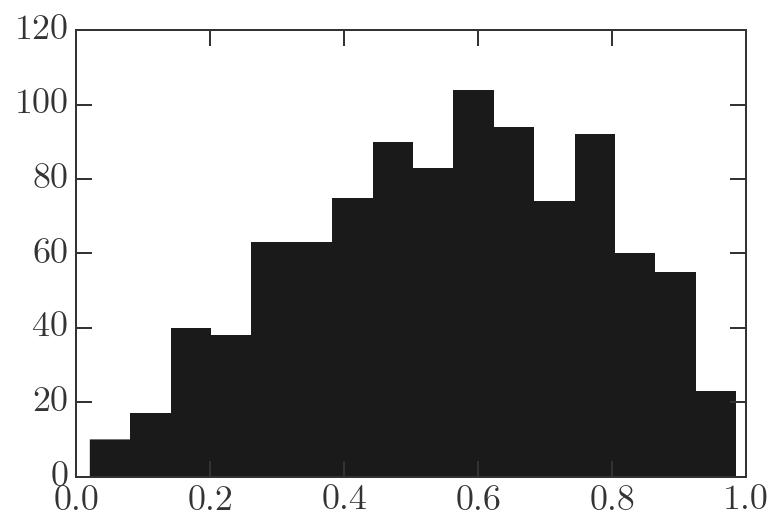

In [153]:
plt.hist(ecc[np.isfinite(ecc)], bins=16);